In [1]:
import math
import datetime
import sys
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

class LR:
    def __init__(self, train_file_name, test_file_name, predict_result_file_name):
        self.train_file = train_file_name
        self.predict_file = test_file_name
        self.predict_result_file = predict_result_file_name
        self.max_iters = 300
        self.rate = 0.1
        self.feats = []
        self.labels = []
        self.feats_test = []
        self.labels_predict = []
        self.param_num = 0
        self.weight = []

In [3]:
def loadDataSet(file_name, label_existed_flag):
    feats = []
    labels = []
    fr = open(file_name)
    lines = fr.readlines()
    for line in lines:
        temp = []
        allInfo = line.strip().split(',')
        dims = len(allInfo)
        if label_existed_flag == 1:
            for index in range(dims-1):
                temp.append(float(allInfo[index]))
            feats.append(temp)
            labels.append(float(allInfo[dims-1]))
        else:
            for index in range(dims):
                temp.append(float(allInfo[index]))
            feats.append(temp)
    fr.close()
    feats = np.array(feats)
    labels = np.array(labels)
    return feats, labels

def loadTrainData(train_file):
    feats, labels = loadDataSet(train_file, 1)
    return feats, labels

def loadTestData(self):
    feats_test, labels_predict = self.loadDataSet(predict_file, 0)
    return feats_test, labels_predict

In [4]:
train_file =  "../data/train_data.txt"
test_file = "../data/test_data.txt"
predict_file = "../projects/student/result.txt"

In [5]:
%%time
X_train, y_train = loadDataSet(train_file, 1)

CPU times: user 3.22 s, sys: 232 ms, total: 3.45 s
Wall time: 3.45 s


In [6]:
%%time
X_test, _ = loadDataSet(test_file, 0)
answer_file = "../projects/student/answer.txt"
_, y_test = loadDataSet(answer_file, 1)

CPU times: user 801 ms, sys: 28.1 ms, total: 829 ms
Wall time: 831 ms


##constants
TRAIN_DIR = "../input/train/"
TEST_DIR = "../input/test/"
TRAIN_SIZE = 25000
TEST_SIZE = 12500
DEV_RATIO = 0.1
IMAGE_HEIGHT = IMAGE_WIDTH = 128

LEARNING_RATE = 0.0001
MINIBATCH_SIZE = 32
INPUT_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH * 3
OUTPUT_SIZE = 2

### Load and prep the data

### Building the parts of our algorithm.

<img src="http://p1plx6n23.bkt.clouddn.com/LogReg_kiank.png">

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [7]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    s = 1.0/(1.0 + np.exp(-1.0 * z))
    
    return s

In [8]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros(shape=(dim, 1), dtype=np.float32)
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [9]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    #### W: shape of (num_px * num_px * 3, 1)
    #### X: shape of (num_px * num_px * 3, number of examples)
    #### Y: shape of (1, number of examples)
    #print("shape of w", w.shape)
    #print("shape of X", X.shape)
    Z= np.matmul(w.T, X) + b
    #print("shape of Z", Z.shape)
    A = sigmoid(Z)        ##### A shape of (1, number of examples)                            # compute activation
    #print("shape of A", A.shape)
    #print("shape of Y", Y.shape)
    cost = (-1.0) * np.mean(np.multiply(Y, np.log(A)) + np.multiply(1.0-Y, np.log(1.0 - A)), axis=1)                                # compute cost
    #print("shape of cost", cost.shape)

    dw = np.matmul(X, np.transpose(A - Y)) * (1.0/m)  ### (n_p*n_p*3, m)(1, m).T=(n_p*n_p*3, 1)
    db = np.mean((A - Y))
    #print("shape of dw", dw.shape)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [10]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [11]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.matmul(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

def predict_test_images(dirname=TEST_DIR, file_count=125):
    test_images, _ = load_data(dirname=dirname, file_count=file_count, shuffle=False)

    res = predict(d['w'], d['b'], test_images)
    res = res.ravel().astype(int)

    res = np.dstack((np.arange(1, res.shape[0]+1), res))[0]
    res_fn = 'result{}.csv'.format(datetime.datetime.now())
    np.savetxt(res_fn, res, fmt='%d,%d',header="id,label", comments='')
    return res_fn

### Merge all functions into a model

In [12]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [13]:
##time
d = model(X_train.T, y_train, 
          X_test.T, y_test, 
          num_iterations = 300, learning_rate = 0.01)#, print_cost = True)

train accuracy: 63.1375 %
test accuracy: 68.7 %


> ### Visualizing and Analysis

In [14]:
def plt_costs(d):
    # Plot learning curve (with costs)
    costs = np.squeeze(d['costs'])
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(d["learning_rate"]))
    #plt.show()

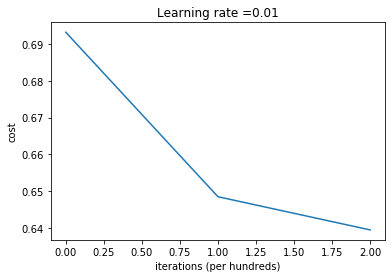

In [15]:
plt_costs(d)

### Lab

##### Use more training data 

##### Use all training data , learning_rate = LEARNING_RATE =  0.001

##### Use all training data , learning_rate =  0.005

##### Use all training data , learning_rate =  0.003

##### Use all training data , learning_rate =  0.001

In [16]:
def learning_rate_lab(learning_rates=[0.0005]):
    m_l = len(learning_rates)
    d_list = []
    for i in range(m_l):
        print("learning_rate:{}, start train model:{}".format(learning_rates[i], datetime.datetime.now()))
        d = model(X_train.T, y_train, X_test.T, y_test, num_iterations = 500, learning_rate = learning_rates[i], print_cost = True)
        print("learning_rate:{}, end train model:{}".format(learning_rates[i], datetime.datetime.now()))
        d_list.append(d)
    for i in range(len(d_list)):
        plt.subplot(321+i, facecolor='y')
        plt_costs(d_list[i])
    return d_list

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.672772
Cost after iteration 200: 0.664227
Cost after iteration 300: 0.660576
Cost after iteration 400: 0.658976
train accuracy: 63.1375 %
test accuracy: 68.7 %
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.668193
Cost after iteration 200: 0.660924
Cost after iteration 300: 0.658705
Cost after iteration 400: 0.657968
train accuracy: 63.1375 %
test accuracy: 68.7 %
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.657669
Cost after iteration 200: 0.657101
Cost after iteration 300: 0.656613
Cost after iteration 400: 0.656128
train accuracy: 63.1375 %
test accuracy: 68.7 %
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.657400
Cost after iteration 200: 0.656711
Cost after iteration 300: 0.656031
Cost after iteration 400: 0.655354
train accuracy: 63.1375 %
test accuracy: 68.7 %
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.657101
Cost after iteration 200: 0.656128
Cost after it

[{'costs': [array(0.69314718),
   array(0.67277167),
   array(0.66422682),
   array(0.66057594),
   array(0.65897552)],
  'Y_prediction_test': array([[0., 0., 0., ..., 0., 0., 0.]]),
  'Y_prediction_train': array([[0., 0., 0., ..., 0., 0., 0.]]),
  'w': array([[-0.00097904],
         [-0.00100467],
         [-0.00098591],
         [-0.00105608],
         [-0.00108348],
         [-0.00101093],
         [-0.00079359],
         [-0.00096339],
         [-0.00071877],
         [-0.00088101],
         [-0.00089919],
         [-0.00102419],
         [-0.00093878],
         [-0.00082895],
         [-0.00097601],
         [-0.00078933],
         [-0.00100513],
         [-0.00090077],
         [-0.00079841],
         [-0.001102  ],
         [-0.00093738],
         [-0.00090236],
         [-0.00094828],
         [-0.00099487],
         [-0.00065828],
         [-0.00080744],
         [-0.00097697],
         [-0.00073646],
         [-0.00093869],
         [-0.00098892],
         [-0.00111264],
    

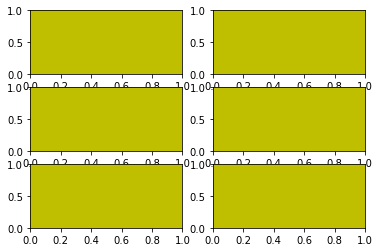

In [26]:
learning_rate_lab([0.00007, 0.0001, 0.0005, 0.0007, 0.001, 0.005])

learning_rate:0.0007, start train model:2020-03-18 18:44:27.019376
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.657400
Cost after iteration 200: 0.656711
Cost after iteration 300: 0.656031
Cost after iteration 400: 0.655354
train accuracy: 63.1375 %
test accuracy: 68.7 %
learning_rate:0.0007, end train model:2020-03-18 18:44:31.965037
learning_rate:0.0008, start train model:2020-03-18 18:44:31.965095
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.657298
Cost after iteration 200: 0.656516
Cost after iteration 300: 0.655740
Cost after iteration 400: 0.654968
train accuracy: 63.1375 %
test accuracy: 68.7 %
learning_rate:0.0008, end train model:2020-03-18 18:44:37.333256
learning_rate:0.0009, start train model:2020-03-18 18:44:37.333396
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.657199
Cost after iteration 200: 0.656322
Cost after iteration 300: 0.655450
Cost after iteration 400: 0.654583
train accuracy: 63.1375 %
test accuracy: 68.7 %
learni

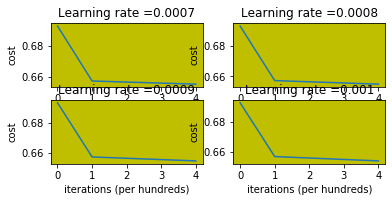

In [17]:
d_list = learning_rate_lab([0.0007, 0.0008, 0.0009, 0.001])